In [1]:
# ===== Reduced Order Modeling with NGSolve + pyMOR (POD-Galerkin) =====
from ngsolve import *
from ngsolve import Mesh
from ngsolve import x, y, z
from ngsolve.webgui import Draw
from netgen.geom2d import unit_square
from netgen.occ import *

from pymor.algorithms.pod import pod
from pymor.vectorarrays.numpy import NumpyVectorSpace
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np


In [2]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1,quad_dominated=True))

E = 5e6 # Youngs module
nu = 0.25 # Poisson ratio
lam = E*nu / ((1+nu)*(1-2*nu))
G  = E / (2*(1+nu))

V = VectorH1(mesh, order=2, dirichlet="left")
u, v = V.TnT()

def eps(w):   return 0.5*(Grad(w)+Grad(w).trans)
def sigma(w): return 2*G*eps(w) + lam*Trace(eps(w))*Id(w.dim)

a = BilinearForm(V)
a += InnerProduct(sigma(u), eps(v))*dx

rho, g = 7850, 9.81
f = LinearForm(V)
f += CoefficientFunction((0,-rho*g)) * v * dx

# Assemble & solve 
gfu = GridFunction(V)
a.Assemble(); f.Assemble()
inv = a.mat.Inverse(V.FreeDofs(), inverse="sparsecholesky")
gfu.vec.data = inv * f.vec

deform = GridFunction(VectorH1(mesh, order=2))


In [3]:
def solve_full(mu_i):
    del_x, del_y = mu_i
    deform.Interpolate((x*y*del_x, x*y*del_y))
    mesh.SetDeformation(deform)

    V = VectorH1(mesh, order=2, dirichlet="left")
    u, v = V.TnT()
    a = BilinearForm(V)
    a += InnerProduct(sigma(u), eps(v)) * dx
    f = LinearForm(V)
    f += CoefficientFunction((0, -rho*g)) * v * dx

    gfu = GridFunction(V)
    a.Assemble(); f.Assemble()
    inv = a.mat.Inverse(V.FreeDofs(), inverse="sparsecholesky")
    gfu.vec.data = inv * f.vec

    mesh.UnsetDeformation()
    return np.array(gfu.vec), a.mat, np.array(f.vec)

In [4]:
# parameter grid
DX_MAX, DY_MAX = 0.3, 0.3
N = 8
dx_vals = np.linspace(-DX_MAX, DX_MAX, N)
dy_vals = np.linspace(-DY_MAX, DY_MAX, N)
mu = np.array([(dx, dy) for dx in dx_vals for dy in dy_vals])
max_modes = 100

# collect full-order snapshots and operators
snapshots = []
As = []
fs = []

for mup in mu:
    u_vec, mat, f_vec = solve_full(mup)
    snapshots.append(u_vec)
    As.append(mat)
    fs.append(f_vec)

snapshots = np.array(snapshots)       # shape (nsnaps, ndofs)
nsnaps, ndofs = snapshots.shape

space = NumpyVectorSpace(ndofs)
S = space.make_array(snapshots)       # pyMOR VectorArray

RB, svals = pod(S, modes=min(max_modes, nsnaps))

Vrb = RB.to_numpy().T
r = Vrb.shape[1]

print(f"Modes: {r}, Snapshots: {len(mu)}")

def apply_Acomp(vec_full: np.ndarray, amat):
    vin = amat.CreateColVector()
    vin.FV().NumPy()[:] = vec_full
    vout = amat.CreateColVector()
    vout.data = amat * vin    # assign the expression into vout

    return vout.FV().NumPy().copy()

Ars = []
for mat in As:
    M = np.column_stack([apply_Acomp(Vrb[:, j], mat) for j in range(r)])
    Ar = Vrb.T @ M
    Ars.append(Ar)
    
del As
Ars = np.array(Ars)

frs = []
for f_vec in fs:
    fr = Vrb.T @ f_vec     # shape (r,)
    frs.append(fr)

frs = np.array(frs)        # shape (nsnaps, r)


Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

Modes: 36, Snapshots: 64


In [5]:
def draw_solution(u_rb, mu_test):
    """Put lifted solution u_rb (numpy) into GridFunction and draw."""
    del_x, del_y = mu_test
    deform.Interpolate((x*y*del_x, x*y*del_y))
    mesh.SetDeformation(deform)

    gfu_vis = GridFunction(V)
    gfu_vis.vec.FV().NumPy()[:] = u_rb
    Draw(gfu_vis, mesh, "u_rb")
    mesh.UnsetDeformation()
    return 

k = -1
draw_solution(snapshots[k],mu[k])
print(mu[k])

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

[0.3 0.3]


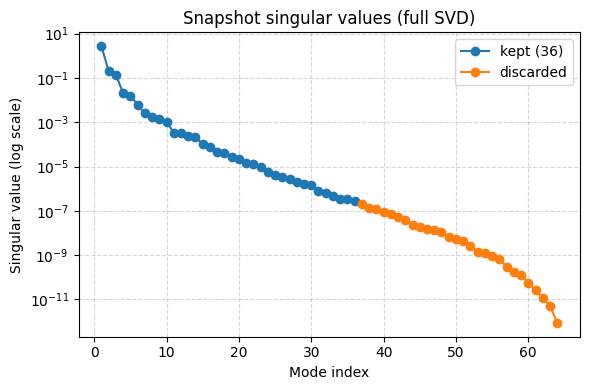

Sum of square singular values beyond cutoff (36): 8.048e-07
S ratio (tail) 2.6068e-07
S ratio (first) (36): 1.0000e+00


In [6]:
# stack snapshots into a matrix: (nsnaps, N)
svals_full = np.linalg.svd(snapshots, compute_uv=False)

# indices
k = np.arange(1, len(svals_full)+1)

plt.figure(figsize=(6,4))
plt.semilogy(k[:r], svals_full[:r], 'o-', color='C0', label=f'kept ({r})')
plt.semilogy(k[r:], svals_full[r:], 'o-', color='C1', label='discarded')

plt.xlabel("Mode index")
plt.ylabel("Singular value (log scale)")
plt.title("Snapshot singular values (full SVD)")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.tight_layout()
plt.show()

s_squared = svals_full
tail_sum_s_vals = s_squared[r:].sum()
sum_first_r_s_vals = s_squared[:r].sum()

error_ratio_first = sum_first_r_s_vals / s_squared.sum()
error_ratio_tail = tail_sum_s_vals / s_squared.sum()
print(f"Sum of square singular values beyond cutoff ({r}): {tail_sum_s_vals:.3e}")
print(f"S ratio (tail) {error_ratio_tail:.4e}")
print(f"S ratio (first) ({r}): {error_ratio_first:.4e}")


In [13]:
from numpy.polynomial.legendre import Legendre
P = 4

def legendre_basis(mu, P):
    """Tensor-product Legendre basis up to degree P"""
    del_x, del_y = mu
    Lx = [Legendre.basis(i)(del_x) for i in range(P+1)]   # evaluate P_i(x)
    Ly = [Legendre.basis(j)(del_y) for j in range(P+1)]   # evaluate P_j(y)
    return [lx * ly for lx in Lx for ly in Ly]

# build design matrix
B = np.array([legendre_basis(m, P) for m in mu])  # (nsnaps, Q)
print("B shape:", B.shape)

Q = B.shape[1]

BTinvBBT = np.linalg.inv(B.T@B)@B.T

Ar_coeffs = np.zeros((r, r, Q))
fr_coeffs = np.zeros((r, Q))

for i in range(r):
    for j in range(r):
        Ars_ij = Ars[:,i,j] # Vector of the i,j component of of the Ars matrices.
        c_ij = BTinvBBT@Ars_ij # Vector containing the coefficients for the legendre polynomials
        Ar_coeffs[i,j,:] = c_ij
for i in range(r):
    f_ij = frs[:,i]
    c_i = BTinvBBT@f_ij
    fr_coeffs[i,:] = c_i

def assemble_reduced(mu):
    theta = legendre_basis(mu,P)
    Ar_mu = (Ar_coeffs.reshape(r*r, Q) @ theta).reshape(r, r)
    fr_mu = fr_coeffs@theta
    return Ar_mu, fr_mu

def solve_ROM(mu):
    Ar_mu, fr_mu = assemble_reduced(mu)
    u_r = np.linalg.solve(Ar_mu,fr_mu)
    u_ROM = Vrb @ u_r
    return u_ROM

B shape: (64, 25)


In [ ]:
def compute_L2_error(u_rb, u_fom, V):
    """Compute L2 error between reduced solution and FOM solution."""
    gfu_rb  = GridFunction(V); gfu_rb.vec.FV().NumPy()[:]  = u_rb
    gfu_fom = GridFunction(V); gfu_fom.vec.FV().NumPy()[:] = u_fom

    diff = gfu_fom - gfu_rb
    l2_err = sqrt(Integrate(InnerProduct(diff, diff), mesh))
    l2_fom = sqrt(Integrate(InnerProduct(gfu_fom, gfu_fom), mesh))

    return l2_err, l2_err / l2_fom

mu_test = [0.3,0.3]
u_ROM = solve_ROM(mu_test)
u_FOM,_,_ = solve_full(mu_test)

l2_err, rel_err = compute_L2_error(u_ROM, u_FOM, V)
print(f"relative L2 error = {rel_err}")

relative L2 error = 6.454237046897457e-05


In [ ]:
import time
Ntests = 100
mu_rand = np.random.uniform(low=[-DX_MAX, -DY_MAX],
                            high=[DX_MAX, DY_MAX],
                            size=(Ntests, 2))

# storage for solutions
u_rb_list = []
u_fom_list = []

# --- ROM timing and solves ---
start_rom = time.time()
for mu_test in mu_rand:
    u_ROM = solve_ROM(mu_test)
    u_rb_list.append(u_ROM)
end_rom = time.time()

# --- FOM timing and solves ---
start_fom = time.time()
for mu_test in mu_rand:
    u_fom, _, _ = solve_full(mu_test)
    u_fom_list.append(u_fom)
end_fom = time.time()

# --- Error computation ---
rel_errors = []
for u_rb, u_fom in zip(u_rb_list, u_fom_list):
    _, rel_err = compute_L2_error(u_rb, u_fom, V)
    rel_errors.append(rel_err)

mean_rel_error = np.mean(rel_errors)
max_rel_error = np.max(rel_errors)

print(f"ROM total time for {Ntests} solves: {end_rom - start_rom:.3f} s")
print(f"FOM total time for {Ntests} solves: {end_fom - start_fom:.3f} s")
print(f"Mean relative L2 error over {Ntests} tests: {mean_rel_error:.3e}")
print(f"Max relative error in {Ntests} tests: {max_rel_error:.3e}")



ROM total time for 100 solves: 0.024 s
FOM total time for 100 solves: 1.678 s
Mean relative L2 error over 100 tests: 1.986e-04
Max error in 100 tests: 7.553e-04
